<a href="https://colab.research.google.com/github/AnIsAsPe/Estimacion-probabilidad-conflicto-en-trayectorias-de-vuelos-paralelos/blob/main/Notebooks/Estimaci%C3%B3n_probabilidad_de_conflicto_en_trayectorias_de_vuelo_MonteCarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import math
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Funciones

**covarianza_a()**

$\mathbb{Cov}(error_{a,t},~error_{a,s}) = r_a^2t^2$


In [2]:
# COVARIANZA ALONG TRACK
def covarianza_a(r_a):
      cov_a = pd.DataFrame(np.zeros((21,21)), index=range(21), columns=range(21))
      for s in range(21):
          for t in range(s+1):
                cov_a.loc[t,s] = cov_a.loc[s,t]=(r_a**2)*((t)**2)
      return cov_a

**covarianza_c()**

$\mathbb{Cov}(error_{c,t},~error_{c,s}) = \sigma_c^2(1-e^{-2\frac{r_c}{\sigma_c}vt})e^{-\frac{r_c}{\sigma_c}v(s-t)}$

In [3]:
# COVARIANZA CROSS TRACK

def covarianza_c(sigma_c, r_c, v ):
      cov_c = pd.DataFrame(np.zeros((21,21)), index=range(21), columns=range(21))
      for s in range(21):
          cov_c.loc[s,s] = (sigma_c**2) * (1-np.exp(-2 * r_c * v * (s) /sigma_c))
          for t in range(1,s):
              cov_c.loc[t,s] = cov_c.loc[s,t] = (sigma_c**2)*(1-np.exp(-2*r_c*v*(t)/sigma_c))*np.exp(-r_c*v*(s-t)/sigma_c)
      return cov_c

**simulacion_error()**

In [4]:
def simulacion_error(matriz_covarianza, n_simulaciones = 1):
  error = pd.DataFrame(np.random.multivariate_normal(np.zeros(len(matriz_covarianza)),
                                                       matriz_covarianza,
                                                       size = n_simulaciones),
                              index =['simulación_'+str(a) for a in range(1, n_simulaciones+1)],
                              columns=['min_' + str(t) for t in range(21)])
  return error

**probabilidad_de_conflicto()**

In [28]:
def probabilidad_de_conflicto(velocidad, distancia, r_a, r_c, sigma_c, n_simulaciones):

    # CÁLCULO DE COVARIANZAS
    cov_c = covarianza_c(sigma_c, r_c, velocidad)
    cov_a = covarianza_a(r_a)

    X_a = {}    # diccionario para guardar las cordenadas Along-Track de cada aeronave
    X_c = {}    # diccionario para guardar las coordenadas Cross-Track de cada aeronave

    for aeronave, signo_posicion in zip(['A','B'], (1,-1)):

        # SIMULACIÖN DE LOS ERRORES

        error_c = simulacion_error(cov_c, n_simulaciones)
        error_a = simulacion_error(cov_a, n_simulaciones)

        # CÁLCULO DE LAS COORDENADAS Along-Track (X_a = v_por_t + error)

        # Obtenemos v * t para cada t
        v_por_t = pd.Series( velocidad * np.arange(21),
                            index=['min_' + str(t) for t in range(21)])

        X_a[aeronave] = v_por_t + error_a

        # CÁLCULO DE COORDENADAS Cross-Track(

        X_c[aeronave] = error_c +( distancia/2 * signo_posicion)

    # PROBABILIDAD DE CONFLICTO
    a = 0.1
    f_Z = np.min((X_c['A']-X_c['B'])**2+(X_a['A']-X_a['B'])**2, axis=1) < a**2
    probabilidad = f_Z.mean()

    return probabilidad, f_Z

**intervalo_confianza_bernoulli()**

# [Covarianza ](https://en.wikipedia.org/wiki/Covariance) entre dos gausianas

[[ 1.05018612 -0.02729635]
 [-0.02729635  0.97091548]]


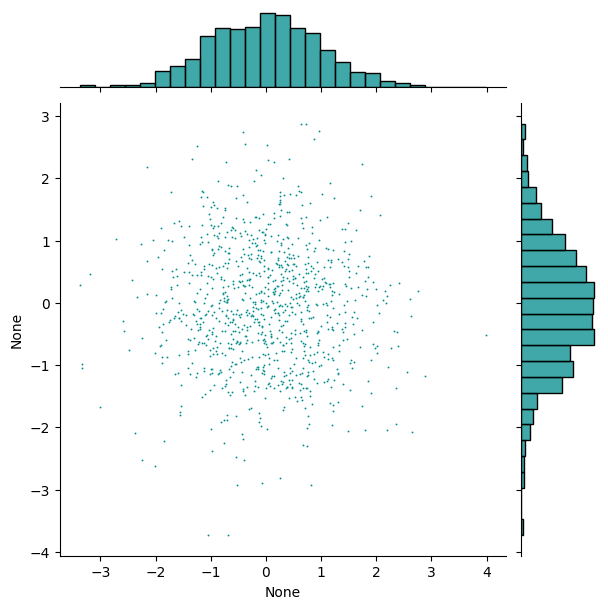

In [ ]:
x1 = np.random.normal(loc=0, scale=1, size = 1000)
y1 = np.random.normal(loc=0, scale = 1, size=1000)
sns.jointplot(x=x1, y= y1, kind = 'scatter', color = 'darkcyan', s = 2 )
M_covarianza1 = np.cov(x1, y1)
print(M_covarianza1)
plt.show()

[[ 1.53 -3.07]
 [-3.07  7.15]]


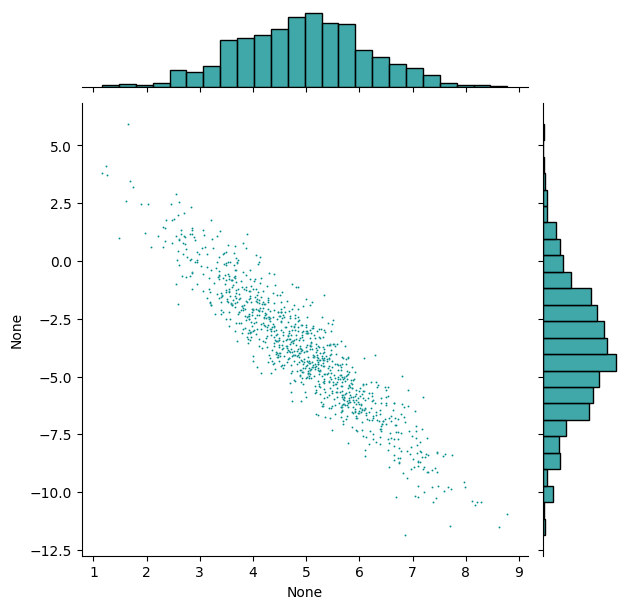

In [ ]:
x2  = np.random.normal(loc=5, scale=1.2, size = 1000)
y2 = 6 - 2*x2 + np.random.normal(size=1000)
sns.jointplot(x=x2, y= y2, kind = 'scatter', color = 'darkcyan', s = 2 )
M_covarianza2 = np.cov(x2, y2)
print(M_covarianza2.round(2))
plt.show()

podríamos generar las coordenadas de puntos aleatoiros por medio de la distribución normal multivariada, ingresando las medias y la matriz de covarianza

In [ ]:
coordenadas = np.random.multivariate_normal(mean = (0,0), cov = M_covarianza2, size = 1000)
coordenadas

array([[ 1.73322478, -2.44119644],
       [ 0.52697846, -1.40256273],
       [-1.10932679,  3.13065248],
       ...,
       [ 1.18774147, -4.13612229],
       [-1.95550177,  4.57764665],
       [ 0.69764899,  0.28207012]])

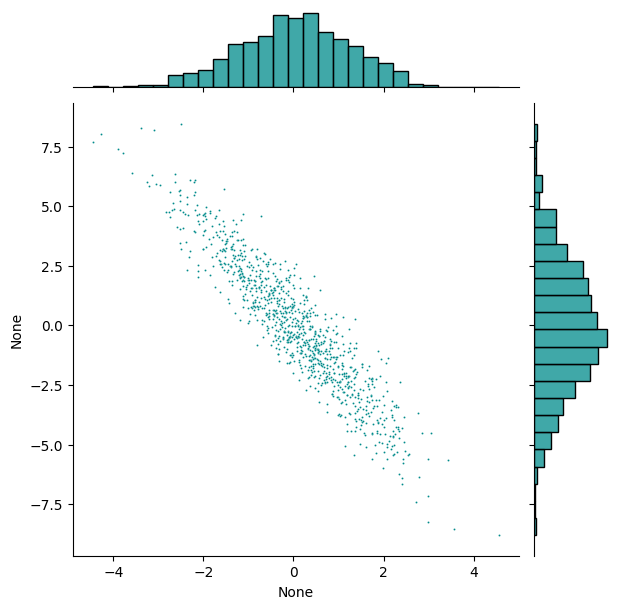

In [ ]:
sns.jointplot(x=coordenadas[:,0], y=coordenadas[:,1], kind = 'scatter',
              color = 'darkcyan', s = 2 )
plt.show()

# Estimacion de la probabilidad de conflicto entre dos aviones
Dos aviones se consideran en conflicto cuando la distancia entre ellos es menor al umbral de 0.1 nmi en algun punto de sus trayectorias.

## 1) Simulación de trayectorias de vuelo
La estimación de probabilidad de conflicto se calcua para trayectorias de 20 min
La trayectoria de cada vuelo se define en el tiempo mediante dos coordenadas $Xa$ y $Xc$


![image.png](https://drive.google.com/uc?id=1KetZH3OEStTkAYjZEtjLJeEY__dMPoEH)

$x_t = (x_{a,t}, x_{c,t})$

$x_{a,t} = vt + error_{a,t}~~~~$  (Along-track component)

$x_{c,t} = error_{c,t}~~~~~~~~~~~~~$       (Cross-track component)


Se simularán coordenadas de cada avion en intervalos regulares de un minuto

### 1.1) Simulación de los errores de las trayectorias en el tiempo

Se asume que tienen una distribución gaussiana multivariada. Sabemos como calcular la covarianza de los errores en el tiempo:







**Tanto para el componente along-track, como para el corss-track.**

$\mathbb{Cov}(error_{a,t},~error_{a,s}) = r_a^2t^2$

$\mathbb{Cov}(error_{c,t},~error_{c,s}) = \sigma_c^2(1-e^{-2\frac{r_c}{\sigma_c}vt})e^{-\frac{r_c}{\sigma_c}v(s-t)}$


---
R. A. Paielli y H. Erzberger, «Conflict Probability Estimation for Free Flight», Journal of Guidance, Control, and Dynamics, may 2012, doi: 10.2514/2.4081.


In [6]:
v = 3           # velocidad (nmi/min)(nmi -> millas naúticas)

# Para aviones con turbina civil se tiene
r_c = 1/57      #  nmi/min
sigma_c = 1     #  nmi
r_a = 0.25      #  nmi/min

# CÁLCULO DE COVARIANZAS
cov_c = covarianza_c(sigma_c, r_c, v)
cov_a = covarianza_a(r_a)

Ahora, podemos simular los errores tanto en la componente along, como en la componente cross

In [7]:
# Para la componente cross
n_simulaciones = 1
errores_c = np.random.multivariate_normal(np.zeros(21), cov_c,  size = n_simulaciones)
errores_a = np.random.multivariate_normal(np.zeros(21), cov_a,  size = n_simulaciones)

In [8]:
errores_a

array([[ 0.        , -0.50443511, -0.07285931,  0.37333865,  0.25505957,
         0.04943841, -0.21756477,  1.26205395, -0.54232446, -1.17744124,
        -0.8434315 , -1.02804915, -1.83435084, -1.4340304 , -2.326022  ,
        -2.8461594 , -3.74259757, -4.93067241, -3.73041173, -2.8459973 ,
        -0.23847744]])

In [9]:
errores_c

array([[ 0.        ,  0.35171205, -0.23178642, -0.17087599,  0.3107186 ,
         0.5659261 ,  0.5652137 ,  0.21670653,  1.14786933,  1.19994187,
         1.41413272,  1.56692199,  1.64418206,  1.65535273,  1.42055063,
         1.21201964,  1.30074288,  1.3321751 ,  1.09549197,  0.80875518,
         1.15163935]])

### 1.2) Simulación de trayectorias

In [10]:
d = 2           # distancia entre trayectorias
n = 100          # número de simulaciones

X_a = {}    # diccionario para guardar las cordenadas Along-Track de cada aeronave
X_c = {}    # diccionario para guardar las coordenadas Cross-Track de cada aeronave

for aeronave, signo_posicion in zip(['A','B'], (1,-1)):

    # SIMULACIÓN DE LOS ERRORES

    error_c = simulacion_error(cov_c, n_simulaciones = n)
    error_a = simulacion_error(cov_a, n_simulaciones = n)

    # CÁLCULO DE LAS COORDENADAS Along-Track (X_a = v_por_t + error)

    # Obtenemos v * t para cada t
    v_por_t = pd.Series( v * np.arange(21),
                        index=['min_' + str(t) for t in range(21)])

    X_a[aeronave] = v_por_t + error_a

    # CÁLCULO DE COORDENADAS Cross-Track(

    X_c[aeronave] = error_c +( d/2 * signo_posicion)

In [11]:
X_a['A'].head(3)

,min_0,min_1,min_2,min_3,min_4,min_5,min_6,min_7,min_8,min_9,...,min_11,min_12,min_13,min_14,min_15,min_16,min_17,min_18,min_19,min_20
simulación_1,0.0,3.071833,6.663825,9.587649,12.778971,14.192425,19.735355,24.406665,28.618977,30.061441,...,33.967648,38.780335,42.561799,46.382779,51.212644,53.994468,57.964600,61.858629,66.351350,70.422081
simulación_2,0.0,3.266936,6.596969,9.819792,13.829571,17.146339,19.312117,24.029740,25.572126,28.448451,...,35.892351,39.712438,40.602942,43.165253,46.937129,49.752560,53.720770,54.803763,58.182841,60.407108
simulación_3,0.0,3.299119,6.815361,9.089682,10.938069,13.029696,15.920196,18.133819,21.170868,23.909968,...,29.341306,31.765369,35.960552,40.499583,45.920801,47.954016,49.914772,50.870004,53.962742,57.199312


In [13]:
X_c['A'].head(3)

,min_0,min_1,min_2,min_3,min_4,min_5,min_6,min_7,min_8,min_9,...,min_11,min_12,min_13,min_14,min_15,min_16,min_17,min_18,min_19,min_20
simulación_1,1.0,0.500729,0.746410,0.827915,0.849865,1.523989,1.103183,1.151729,1.237328,0.960195,...,0.952484,0.960798,0.923743,0.499982,1.079464,1.016357,1.199868,1.473629,1.623187,1.294977
simulación_2,1.0,0.859701,0.421871,0.448831,0.323094,0.148138,0.276431,-0.102044,0.118860,0.236106,...,0.202045,-0.016718,0.420751,0.882760,1.384166,1.487920,1.036745,1.085322,1.217287,1.481341
simulación_3,1.0,1.107770,1.246043,1.399558,1.336860,1.742313,1.584434,1.878561,2.081324,1.710918,...,1.362124,1.469836,1.089319,0.631188,0.792169,0.792936,0.604224,0.656739,0.416397,0.237684


In [14]:
X_a['B'].head(3)

,min_0,min_1,min_2,min_3,min_4,min_5,min_6,min_7,min_8,min_9,...,min_11,min_12,min_13,min_14,min_15,min_16,min_17,min_18,min_19,min_20
simulación_1,0.0,2.857882,6.091230,9.200338,12.741682,14.553275,17.258687,20.030568,23.004887,26.679588,...,32.109087,32.629778,36.720156,39.906956,43.132951,47.376060,51.094476,56.034190,61.683520,64.967370
simulación_2,0.0,2.770969,6.529926,10.215936,14.099268,16.977616,19.142219,21.970879,23.664932,26.509844,...,33.628626,38.161960,41.154070,44.153121,48.510971,50.173489,55.950384,59.383910,66.208690,69.097418
simulación_3,0.0,2.576131,5.835433,8.772994,11.140859,14.658345,18.429451,21.501327,24.615826,28.018507,...,34.155882,36.239927,41.116012,45.969979,48.316183,51.310642,54.628298,58.224476,60.977697,63.397701


In [15]:
X_c['B'].head(3)

,min_0,min_1,min_2,min_3,min_4,min_5,min_6,min_7,min_8,min_9,...,min_11,min_12,min_13,min_14,min_15,min_16,min_17,min_18,min_19,min_20
simulación_1,-1.0,-1.947436,-2.219324,-1.994045,-2.008088,-1.742818,-1.388914,-1.133828,-0.891527,-0.559723,...,-0.475471,-0.685353,-0.007203,-0.300395,-0.560643,-0.112827,0.469670,0.840163,1.500093,1.432318
simulación_2,-1.0,-0.958170,-0.990379,-0.886794,-0.650745,-0.796038,-0.996136,-0.951230,-0.916074,-1.226617,...,-1.165163,-0.936603,-0.725542,-1.048979,-0.421914,-0.581006,-0.847850,-0.816049,-0.587911,-0.219196
simulación_3,-1.0,-1.076650,-1.426697,-1.473210,-1.167370,-1.113835,-1.893388,-2.338918,-1.785235,-1.160734,...,-0.708221,-0.869033,-1.304821,-1.551234,-0.790116,-0.926330,-0.428825,-0.561016,-0.541694,-0.834839


#### 1.3.3 Visualización de las trayectorias

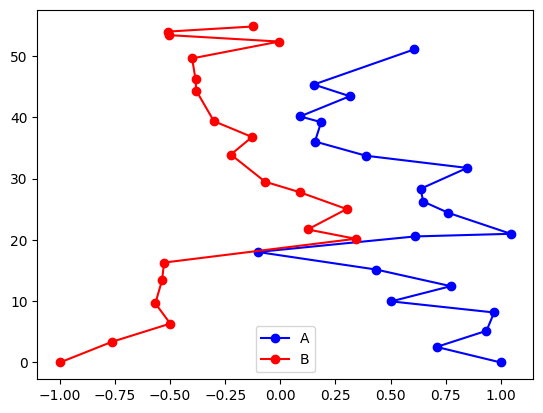

In [18]:
n_sim = 36
plt.figsize =(10,10)
plt.plot(X_c['A'].loc['simulación_'+str(n_sim)].T, X_a['A'].loc['simulación_'+str(n_sim)].T, 'o-', color='b', label='A')
plt.plot(X_c['B'].loc['simulación_'+str(n_sim)].T, X_a['B'].loc['simulación_'+str(n_sim)].T, 'o-', color='r', label='B')
leg = plt.legend(loc='lower center')
plt.show()


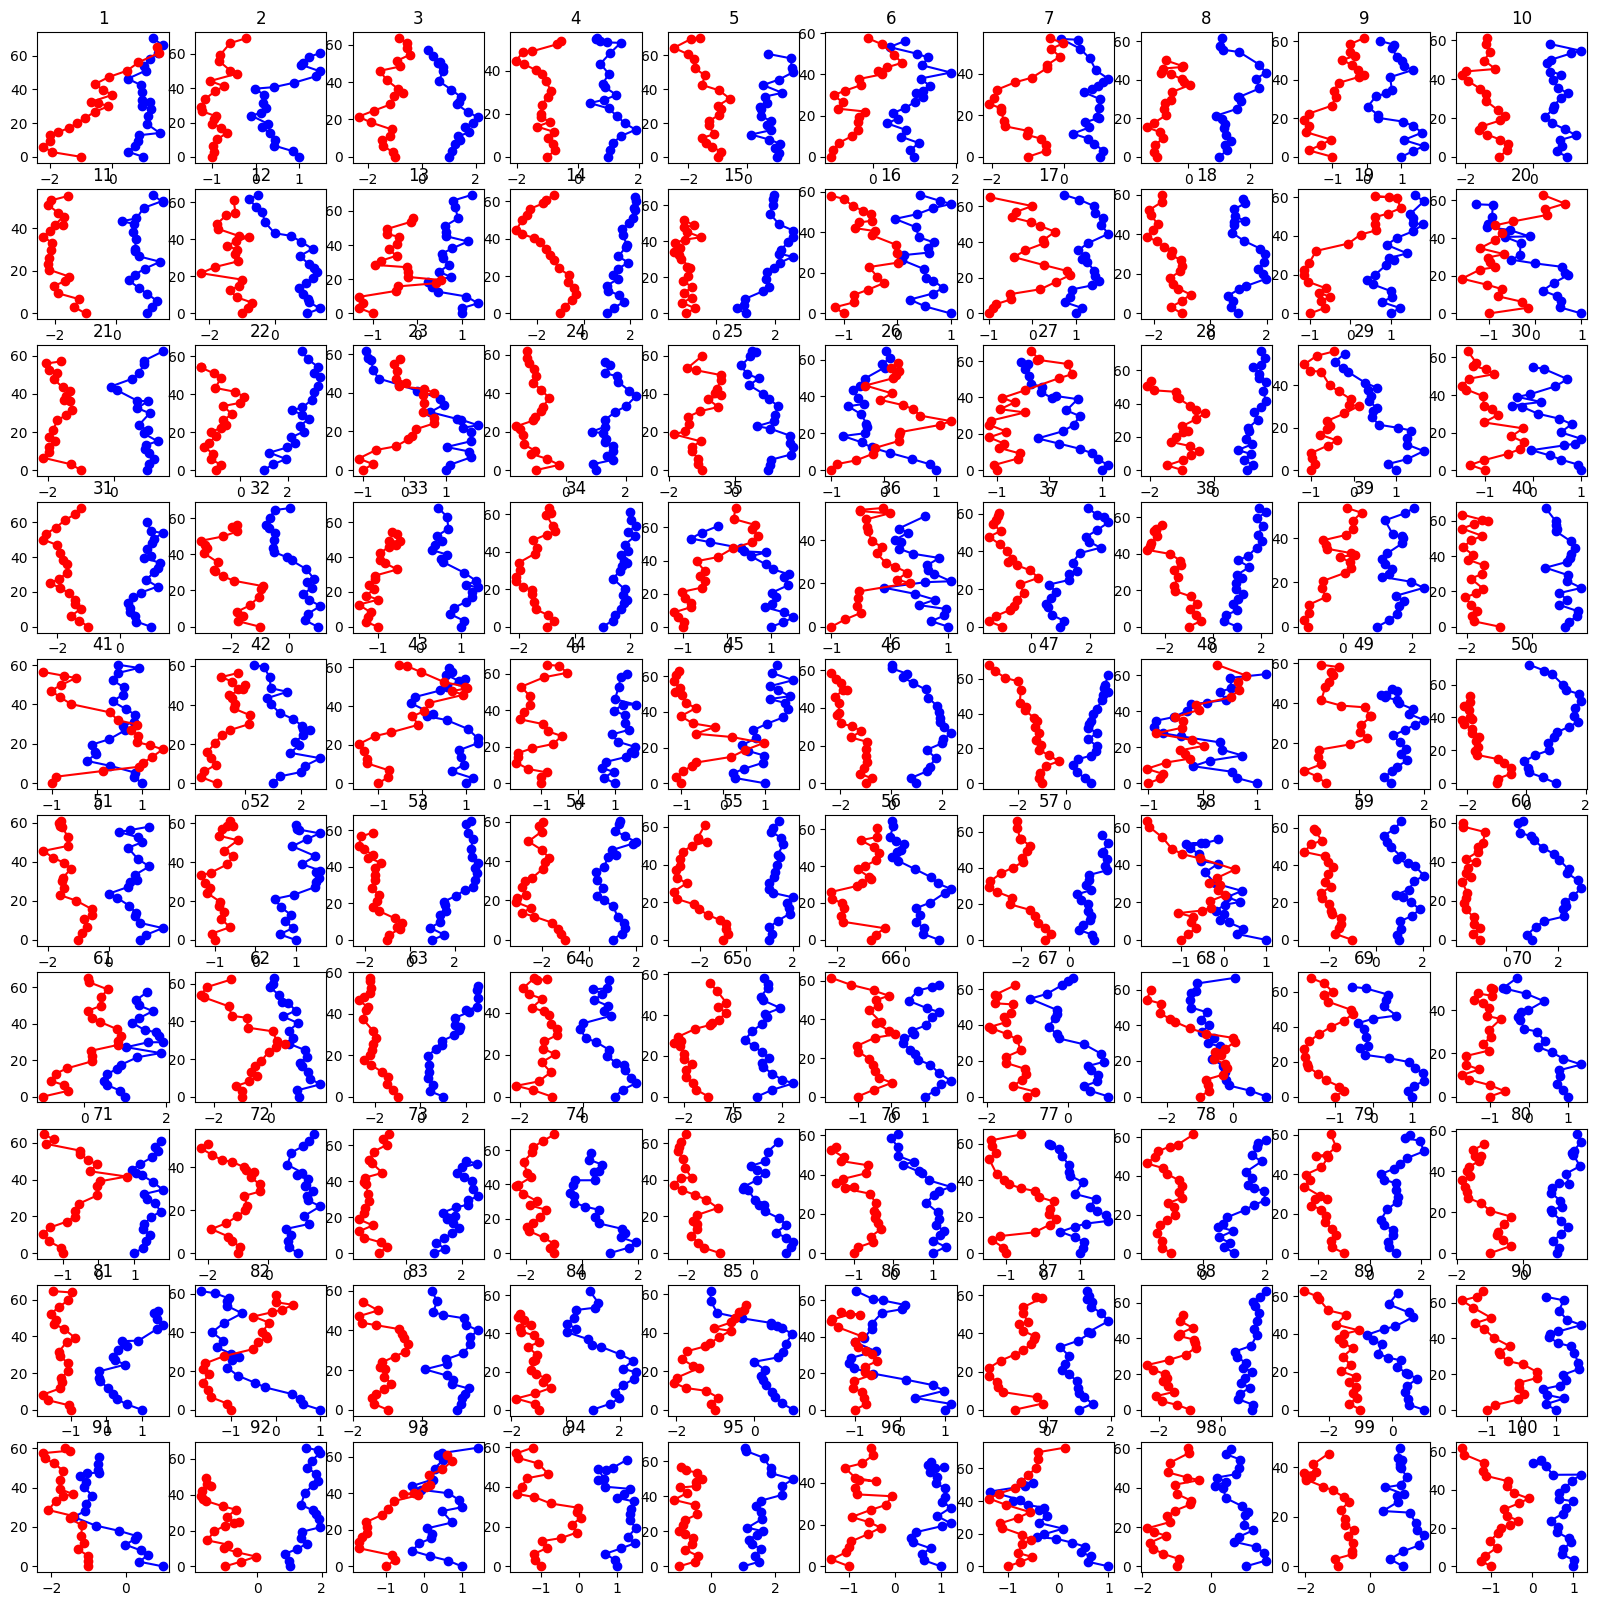

In [17]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for simulacion, subplot in zip(range(1,101), ax.flatten()):

    subplot.plot(X_c['A'].loc['simulación_'+str(simulacion)].T,
             X_a['A'].loc['simulación_'+str(simulacion)].T, 'o-', color='b')
    subplot.plot(X_c['B'].loc['simulación_'+str(simulacion)].T,
                 X_a['B'].loc['simulación_'+str(simulacion)].T, 'o-', color='r')
    subplot.set_title( str(simulacion))
plt.show()

### 1.3 Distancia entre dos trayectorias paralelas

In [20]:
Z = np.sqrt((X_c['A'] - X_c['B'])**2 + (X_a['A'] - X_a['B'])**2)
Z

,min_0,min_1,min_2,min_3,min_4,min_5,min_6,min_7,min_8,min_9,...,min_11,min_12,min_13,min_14,min_15,min_16,min_17,min_18,min_19,min_20
simulación_1,2.0,2.457496,3.020504,2.848414,2.858196,3.286676,3.513465,4.937002,6.004167,3.707705,...,2.343780,6.367038,5.915358,6.525097,8.244477,6.714043,6.908820,5.858785,4.669453,5.456440
simulación_2,2.0,1.884314,1.413840,1.393135,1.010494,0.959132,1.283859,2.227111,2.169903,2.428529,...,2.644562,1.802823,1.271900,2.169677,2.395602,2.111312,2.919397,4.959129,8.226359,8.855129
simulación_3,2.0,2.300957,2.846717,2.890171,2.512428,3.287869,4.288544,5.396965,5.178611,5.012631,...,5.240847,5.048959,5.684248,5.889668,2.870798,3.771314,4.825403,7.454608,7.080081,6.290495
simulación_4,2.0,1.803670,2.148624,2.532338,2.851666,3.253123,3.648238,4.485303,5.279782,3.078806,...,2.542102,2.450044,2.175658,3.722241,5.810277,8.981181,5.161749,6.443205,2.187848,1.390298
simulación_5,2.0,2.090483,2.252790,2.562192,2.500726,1.274904,3.733576,2.929803,3.877018,4.483167,...,5.190253,7.619733,7.208263,10.581479,10.387240,12.835241,11.338097,12.335660,12.105720,9.584811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
simulación_96,2.0,2.074139,1.871731,1.895849,1.387394,2.194399,2.293876,2.483484,3.685617,3.329733,...,2.909834,2.192096,1.986259,2.496402,2.421648,3.347049,2.191577,2.825480,4.629687,7.058451
simulación_97,2.0,1.356860,1.237373,1.305377,1.899378,1.769436,2.558955,5.823418,6.575192,6.734942,...,6.874580,7.022141,8.630355,10.312005,11.758360,14.954257,14.679509,16.634478,19.067294,20.897971
simulación_98,2.0,2.607691,2.977519,3.132529,2.488913,2.191190,2.967964,3.270286,4.106629,3.204983,...,3.321275,6.580160,4.386142,2.110603,1.405236,2.188214,2.910997,2.594880,1.201626,1.399945
simulación_99,2.0,1.703919,1.970758,2.965291,3.729712,3.074385,3.401688,5.206570,3.444183,3.637825,...,2.121947,2.037579,2.474040,3.320389,4.477193,5.216613,4.813311,5.377041,3.743255,3.235753


<Axes: >

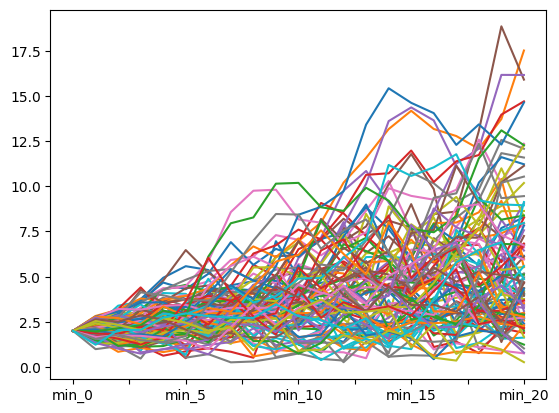

In [ ]:
Z.T.plot(legend=False)

## 2) Estimación de la probabilidad de conflicto
La estimación de probabilidad de conflicto se calcua para trayectorias de 20 min
La simulación de la pareja de trayectorias $X_A$ y $X_B$ la denominaremos Z.

La probabilidad de conflicto se puede estimar mediante la aproximación al valor esperado como una función del par de variables Z.

$f(Z) = 1~~~~$   si  $~~~~\displaystyle\min_{1<=t<=20} \lvert X_{A_t} -X_{B_t} \rvert < 0.1$

$f(Z) = 0~~~$   si no.


In [21]:
a = 0.1
f_Z = np.min(Z, axis=1) <= a
p = f_Z.mean()
varianza = p*(1-p)

print(f'Probabilidad ={p}')

Probabilidad =0.0


In [24]:
len(f_Z)

100

In [25]:
def margen_error_bernoulli(tam_muestra, p_muestra , nivel_confianza):
  '''p es la probabilidad obtenida en la muestra
     nivel de confianza debe estar entre 0 y 1'''
  izq = (1 - nivel_confianza)/2
  z_score = - stats.norm.ppf(izq)
  margen_error = z_score/(2*math.sqrt(tam_muestra))
  print('''
  Para un tamaño de muestra de n = {},
  la probabilidad de colisión es de {},
  considerando un nivel de confianza de {},
  el margen de error es de {}'''.format(tam_muestra, p_muestra,
                                                      nivel_confianza, margen_error))


In [26]:
margen_error_bernoulli(n, p, 0.95)


  Para un tamaño de muestra de n = 100,
  la probabilidad de colisión es de 0.0,
  considerando un nivel de confianza de 0.95,
  el margen de error es de 0.0979981992270027


$\epsilon \leq \cfrac{z_{score}}{2\sqrt{n}}$

$n = \cfrac{{z_{score}}^2}{4\epsilon^2}$


In [27]:
nivel_confianza = 0.95
error = 0.001
izq = (1 - nivel_confianza)/2
z_score = - stats.norm.ppf( izq)
N = int((z_score**2)/(4*(error**2)))
N

960364

# TODO JUNTO, utilizando el número de simulaciones estimado

(Para tener una estimación aceptable en términos de nivel de confianza y márgén de error)

In [29]:
p,  f_Z = probabilidad_de_conflicto(velocidad = v, distancia=d,
                                           r_a=r_a, r_c=r_c, sigma_c=sigma_c,
                                           n_simulaciones = N)
print(f'Probabilidad = {p}')

Probabilidad = 0.004157798501401552


In [30]:
f_Z.sum()

np.int64(3993)

In [31]:
margen_error_bernoulli(N, p, 0.95)


  Para un tamaño de muestra de n = 960364,
  la probabilidad de colisión es de 0.004157798501401552,
  considerando un nivel de confianza de 0.95,
  el margen de error es de 0.0010000003671386069


# Probabilidad de conflicto en función de la distancia entre aviones

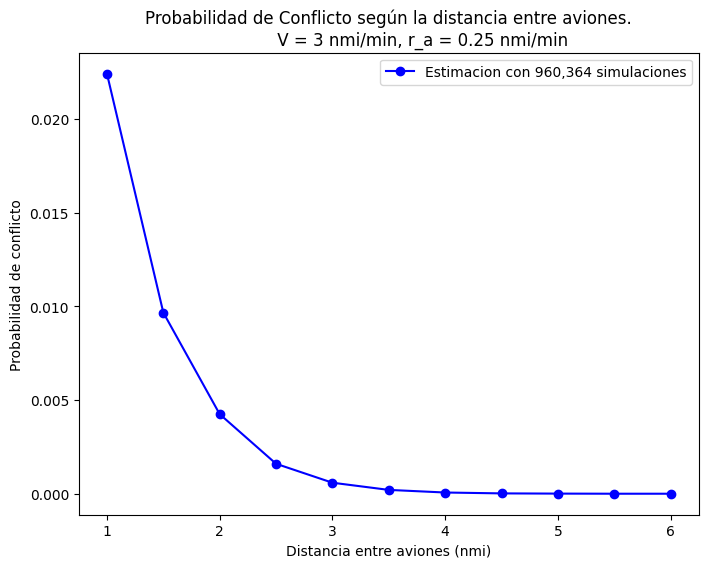

In [ ]:
n = N      # número de simulaciones
distancias =  np.arange(1,6.5,0.5)
probabilidad ={}

for dist in distancias.round(2):
  resultados = probabilidad_de_conflicto(velocidad = v, distancia=dist,
                                         r_a=r_a, r_c=r_c, sigma_c=sigma_c,
                                         n_simulaciones = n)
  probabilidad[dist]= resultados[0]

#Gráfica estimación de p
plt.figure(figsize=(8, 6))
plt.plot(distancias, list(probabilidad.values()), 'o-', color='b', label ='Estimacion con {:,d} simulaciones'.format(n))
plt.xlabel('Distancia entre aviones (nmi)')
plt.ylabel('Probabilidad de conflicto')
plt.title('''Probabilidad de Conflicto según la distancia entre aviones.
             V = {} nmi/min, r_a = {} nmi/min'''.format(v, r_a))
plt.legend()
plt.show()

In [ ]:
probabilidad

{1.0: 0.022404005148048033,
 1.5: 0.00966196150626221,
 2.0: 0.004244224065042005,
 2.5: 0.0015973110195717456,
 3.0: 0.0005872773240146444,
 3.5: 0.00020408928281359984,
 4.0: 6.45588547675673e-05,
 4.5: 1.7701621468526518e-05,
 5.0: 6.247631106538771e-06,
 5.5: 0.0,
 6.0: 0.0}

In [ ]:
probabilidad[5]

6.247631106538771e-06

In [ ]:
margen_error_bernoulli(N, probabilidad[5], 0.95)


  Para un tamaño de muestra de n = 960364,
  la probabilidad de colisión es de 6.247631106538771e-06,
  considerando un nivel de confianza de 0.95,
  el margen de error es de 0.0010000003671386069


In [ ]:
nivel_confianza = 0.95
error = 1e-7
izq = (1 - nivel_confianza)/2
z_score = - stats.norm.ppf( izq)
N = int((z_score**2)/(4*(error**2)))
N

96036470517353

# Consideraciones
-  Para una distancia fija y r_a constante, ¿qué consecuencia tiene aumentar la velocidad de vuelo en  la probabilidad de que ocurra un conflicto? Considerar que la velocidad promedio de un avión es 8 nmi/min